In [1]:
import dynet as dy
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

In [2]:
seaborn.set()
#dy.init()

In [3]:
# creating test cases
def circle_iid(radius, n_points):
    """
    draw points unifrom within a circle in the 2D plane
    """
    radii = np.sqrt(np.random.uniform(high=radius ** 2, size=n_points))
    phi = np.random.uniform(high=2 * np.pi, size=n_points)
    return np.array([radii*np.cos(phi),radii * np.sin(phi)])

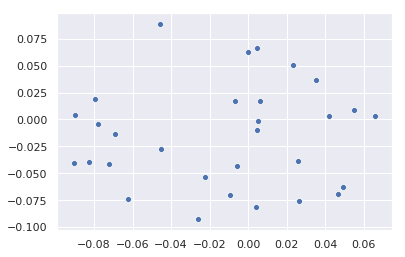

In [4]:
points = circle_iid(0.1, 30)
x = points[0,:]
y = points[1,:]

seaborn.scatterplot(x,y)

### training the network

In [63]:

def create_network():
    dy.renew_cg()
    pc = dy.ParameterCollection()
    W = pc.add_parameters((2,2),name='W')
    b = pc.add_parameters(2, name='b')
    
    return pc, {"W": W, "b": b,}
    
def evaluate_network(params, t, bias = True):
    dy.renew_cg()
    W = params["W"]
    b = params["b"]
    x = dy.vecInput(2)
    # b = dy.vecInput(2)
    x.set(t)
    # b.set(np.array([0.1, 0.2]))
    if bias:
        lin_out = W * (x + b)
    else:
        lin_out = W * x
    output = -dy.rectify(-dy.rectify(lin_out + 1)+2)+1
    return output
   

EPOCHS = 100
def train_network(pc, params, train_data):
    trainer = dy.SimpleSGDTrainer(pc) 

    #W = params["W"]
   
    i = 0 
    for e in range(EPOCHS):
        mloss = 0.
        goods = 0.
        shuffle(train_data)
        for x, y in train_data:
            i = i + 1
            y_vec = np.zeros(2, np.double)
            y_vec[y] = 1
            output = evaluate_network(params, x)
            y_param = dy.vecInput(2)
            y_param.set(y_vec)
            #loss = -dy.log (dy.pick(output,y))
            loss = dy.squared_distance(output,y_param)
            good = y == np.argmax(output.npvalue())
            mloss += loss.value()
            goods += int(good)
            loss.backward()
            trainer.update()
            #print W.npvalue()[0,0]
            
        print("average loss: {} acc: {}".format(mloss/len(train_data), goods/len(train_data)))
        

### the box function as a combination of ReLUs

In [7]:
def relu(x):
    return np.maximum(0,x)
    
def drel(x):
    return -relu(-relu(x+1)+2)+1

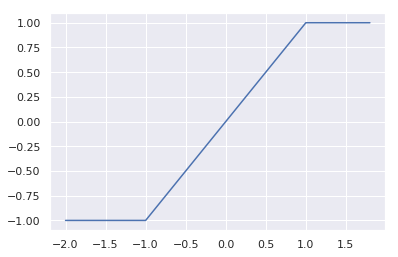

In [8]:
x = np.arange(-2,2,0.2)
plt.plot(x, drel(x))


### creating a test set and training

In [23]:
def create_train_x(centroids, noise, count):
    coord = []
    for i in range(centroids.shape[1]):
        coord.append(circle_iid(noise, count) + centroids[:,i, np.newaxis])
    return np.concatenate(coord, axis=1)

def create_train_data(z_centroids, o_centroids, noise, count):
    train_data = []
    z = create_train_x(z_centroids, noise, count)
    o = create_train_x(o_centroids, noise, count)
    print o.shape
    for i in range(z.shape[1]):
        train_data.append((z[:,i], 0))
    for i in range(o.shape[1]):
        train_data.append((o[:,i], 1))
    return train_data

In [44]:
z_centroids = np.array([[0.5*np.cos(np.pi/6),0.5*np.sin(np.pi/6)]]).T
o_centroids = np.array([
    [0.5*np.cos(np.pi/3),0.5*np.sin(np.pi/3)],
    [0.1*np.cos(np.pi/3),0.1*np.sin(np.pi/3)],
    [0.1*np.cos(np.pi/6),0.1*np.sin(np.pi/6)],
]).T

train_data = create_train_data(z_centroids, o_centroids, 0.02, 30)
train_data[0][0]
print len(train_data)


(2, 90)
120


In [52]:
pc, params = create_network()
len(params)

2

In [53]:
train_network(pc, params, train_data)

average loss: 0.450076700466 acc: 0.725
average loss: 0.258346707832 acc: 0.825
average loss: 0.288403035926 acc: 0.708333333333
average loss: 0.286007032481 acc: 0.716666666667
average loss: 0.285100731054 acc: 0.783333333333
average loss: 0.288639921454 acc: 0.75
average loss: 0.278354103882 acc: 0.8
average loss: 0.287126122342 acc: 0.733333333333
average loss: 0.299014383047 acc: 0.683333333333
average loss: 0.237585854038 acc: 0.8
average loss: 0.289179743855 acc: 0.766666666667
average loss: 0.276287023494 acc: 0.775
average loss: 0.300502625621 acc: 0.8
average loss: 0.263906972377 acc: 0.816666666667
average loss: 0.254951616927 acc: 0.783333333333
average loss: 0.278746741238 acc: 0.808333333333
average loss: 0.288470625653 acc: 0.758333333333
average loss: 0.266678840717 acc: 0.741666666667
average loss: 0.273418355772 acc: 0.758333333333
average loss: 0.267273532796 acc: 0.766666666667
average loss: 0.25622216837 acc: 0.8
average loss: 0.265734520027 acc: 0.783333333333
aver

In [65]:
print params["W"].npvalue()
if "b" in params: print params["b"].npvalue()
print

w = params["W"].npvalue()
b = params["b"].npvalue()
w_inv = np.linalg.inv(w)

print w_inv
print w_inv[:,0].dot(w_inv[:,1])

[[ 0.90010798  0.60404181]
 [-1.63285172  0.70906824]]
[-0.11022964  0.50808841]

[[ 0.4364709  -0.3718213 ]
 [ 1.00511097  0.55406648]]
0.39460911898845


### plot the transfromation on the original axes

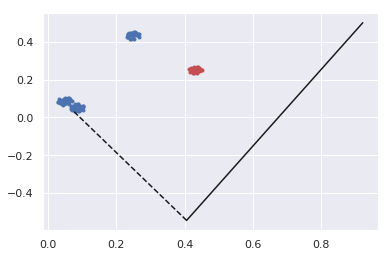

In [60]:

#b = np.array([0.1, 0.2])
#b_inv = w_inv.dot(b)
b_inv = np.array([0,0])
plt.plot([t[0] for t, c in train_data if c ==0], 
         [t[1] for t, c in train_data if c ==0], 'r.',
         [t[0] for t, c in train_data if c ==1],
         [t[1] for t, c in train_data if c ==1], 'b.'
        )

#ft = w_inv.dot(b)
plt.plot([-b[0],  w_inv[0,0]-b[0]],[-b[1], w_inv[1,0]-b[1]], 'k-',
        [-b[0],  w_inv[0,1]-b[0]],[-b[1], w_inv[1,1]-b[1]], 'k--')

### plot the transformed points

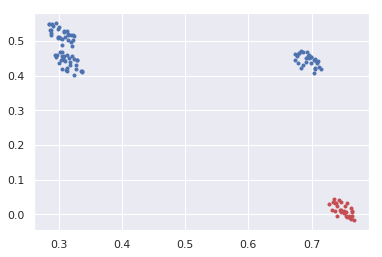

In [62]:
pos = (list(), list())
neg = (list(), list())
for x, y in train_data:
    y_hat =evaluate_network(params, x).value()
    if y:
        add_to= pos
    else:
        add_to = neg
    add_to[0].append(y_hat[0])
    add_to[1].append(y_hat[1])


plt.plot(pos[0], pos[1], 'b.',
        neg[0],neg[1], 'r.')

In [64]:
o_centroids


array([[0.25      , 0.05      , 0.08660254],
       [0.4330127 , 0.08660254, 0.05      ]])

In [17]:
w = params["W"].npvalue()
#b = params["b"].npvalue()[:,np.newaxis]
#print z_centroids
print w[0,:].dot(z_centroids)
print
print w[0,:].dot(o_centroids)

[1.00263127]

[-0.00089475]


In [121]:
print w
print np.linalg.inv(w)
print
#print w_inv.dot(b)

[[ 2.21601057 -3.18235779]
 [-1.92577684  3.48091888]]
[[2.19582791 2.00749005]
 [1.21481559 1.39790039]]



### sandbox

In [28]:
print w.dot(o_centroids)
print
print w.dot(z_centroids)

[[-0.10226798]
 [ 0.80071885]]

[[ 0.90278422]
 [-0.20350841]]


In [32]:
z_centroids

array([[0.4330127],
       [0.25     ]])

In [ ]:
a = np.array([[1,2,3],[1,2,3]])
b = np.array([[4],[5]])
a+b

In [ ]:
a[:,1].shape

In [66]:
p = np.array([
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,0,1,0],
    [0,0,0,0,1],
    [0.25, 0.25, 0.25,0.25,0]
])

In [67]:
p.sum(axis=1)

array([1., 1., 1., 1., 1.])

In [93]:
p1 = p #np.array([1,0,0,0,0])
for r in range(1,10):
    p1 = p1.dot(p)
    print r
    print p1
print 

1
[[0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]
 [0.25 0.25 0.25 0.25 0.  ]
 [0.   0.25 0.25 0.25 0.25]]
2
[[0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     1.    ]
 [0.25   0.25   0.25   0.25   0.    ]
 [0.     0.25   0.25   0.25   0.25  ]
 [0.0625 0.0625 0.3125 0.3125 0.25  ]]
3
[[0.     0.     0.     0.     1.    ]
 [0.25   0.25   0.25   0.25   0.    ]
 [0.     0.25   0.25   0.25   0.25  ]
 [0.0625 0.0625 0.3125 0.3125 0.25  ]
 [0.0625 0.125  0.125  0.375  0.3125]]
4
[[0.25     0.25     0.25     0.25     0.      ]
 [0.       0.25     0.25     0.25     0.25    ]
 [0.0625   0.0625   0.3125   0.3125   0.25    ]
 [0.0625   0.125    0.125    0.375    0.3125  ]
 [0.078125 0.140625 0.203125 0.203125 0.375   ]]
5
[[0.       0.25     0.25     0.25     0.25    ]
 [0.0625   0.0625   0.3125   0.3125   0.25    ]
 [0.0625   0.125    0.125    0.375    0.3125  ]
 [0.078125 0.140625 0.203125 0.203125 0.375   ]
 [0.09375  0.171875 0.234375 0.296

In [72]:
from scipy.linalg import eig

In [77]:
w, vl = eig(p.T);
print w

[-0.60355339+0.36840644j -0.60355339-0.36840644j  0.10355339+0.69948316j
  0.10355339-0.69948316j  1.        +0.j        ]


In [78]:
print vl

[[-0.21913684-0.1337602j  -0.21913684+0.1337602j   0.03208862-0.21675246j
   0.03208862+0.21675246j  0.14744196+0.j        ]
 [-0.05317151+0.18916549j -0.05317151-0.18916549j -0.26449499-0.30653426j
  -0.26449499+0.30653426j  0.29488391+0.j        ]
 [-0.01557358-0.32292569j -0.01557358+0.32292569j -0.45152119+0.08978181j
  -0.45152119-0.08978181j  0.44232587+0.j        ]
 [-0.43827367+0.2675204j  -0.43827367-0.2675204j   0.06417725+0.43350491j
   0.06417725-0.43350491j  0.58976782+0.j        ]
 [ 0.7261556 +0.j          0.7261556 -0.j          0.61975031+0.j
   0.61975031-0.j          0.58976782+0.j        ]]


In [83]:
ep = np.real(vl[:,4])

In [85]:
print ep -ep.dot(p)

[-1.11022302e-16  1.11022302e-16  5.55111512e-17  0.00000000e+00
  0.00000000e+00]


In [92]:
print ep/ep.sum()

[0.07142857 0.14285714 0.21428571 0.28571429 0.28571429]


In [90]:
1./7

0.14285714285714285

In [91]:
ep[2]*7

3.09628107925284

In [97]:
a= np.array([[6,6],[7,7]])

In [98]:
a.shape

(2, 2)

In [101]:
np.diff(a.shape)[0] ==0

True

In [ ]:
np.linalg.in